# Transfer Learning With TensorFlow pt 2: Fine-tuning

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

Previously we were feature extraction tranfer learning - omlu the 'top' layers are trained (layers closest to output)

Fine-tuning generally requires more data, but has a higher potential to fit your data better

## Creating Helper Functions

Throughout machine learning experiments, there are snippets of code you want to use over and over again.

For example, a plotting function which plots a model's history object (see plot_loss_curves() below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as helper_functions.py. And then import the necesary functionality when you need it.

In [3]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2021-11-16 22:54:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-16 22:54:24 (74.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-11-16 22:54:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   130MB/s    in 1.2s    

2021-11-16 22:54:28 (130 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

## Loading the Data into TensorFlow using image_dataset_from_directory instead of ImageDataGenerator

Both work, but image_dataset_from_directory creates a tf.data.Dataset object rather than a generator.

image_data_from_directory API is much faster

In [7]:
# create data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir, 
                                                                    label_mode="categorical",
                                                                    image_size = IMG_SIZE,
                                                                    batch_size = 32)

test_data_10 = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir, 
                                                                   label_mode="categorical",
                                                                    image_size = IMG_SIZE,
                                                                    batch_size = 32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10
# none is the batch size
# (none, 10) refers to the tensor shape of the labels where None is the batch size
# and 10 is the number of possible labels
# Both image tensors and labels are of the datatype tf.float32.

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# There are also useful methods when using the tf.data.Dataset API
# ex. check classes
train_data_10.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# see an example batch of data
for images, labels in train_data_10.take(1): 
  print(images, labels)

tf.Tensor(
[[[[9.14285736e+01 5.25867348e+01 5.16887779e+01]
   [8.32244873e+01 4.77193871e+01 5.15510216e+01]
   [6.75306091e+01 3.54489784e+01 4.57500000e+01]
   ...
   [1.26642860e+02 6.04438972e+01 2.52194672e+01]
   [1.18765274e+02 5.45714149e+01 2.29744854e+01]
   [1.04055611e+02 4.18158836e+01 1.35862684e+01]]

  [[1.00438774e+02 7.59846954e+01 7.39846954e+01]
   [1.10010216e+02 8.66428680e+01 9.22245026e+01]
   [9.03928604e+01 7.06071396e+01 7.95357208e+01]
   ...
   [1.31586868e+02 6.19286804e+01 2.53726215e+01]
   [1.25499947e+02 5.96479225e+01 2.59285583e+01]
   [1.14377235e+02 5.01834221e+01 1.79231834e+01]]

  [[1.42974487e+02 1.36336731e+02 1.34750000e+02]
   [1.10801010e+02 1.03102028e+02 1.08387741e+02]
   [5.41224403e+01 4.83163185e+01 5.62704010e+01]
   ...
   [1.32020447e+02 5.82347069e+01 1.88061790e+01]
   [1.30341827e+02 5.98571548e+01 2.41122646e+01]
   [1.27642685e+02 5.94233932e+01 2.58519287e+01]]

  ...

  [[4.86429214e+01 1.94286594e+01 1.14286585e+01]
   [4

In [11]:
# note that the labels are one-hot encoded

## Model 0:

Note:  the tf.keras.applications module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

For model 0 we go through the following steps

1. Instantiate a pre-trained base model object by choosing a target model such as EfficientNetB0 from tf.keras.applications, setting the include_top parameter to False (we do this because we're going to create our own top, which are the output layers for the model).
1.Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model.
1.Define an input layer for our model, for example, what shape of data should our model expect?
1.[Optional] Normalize the inputs to our model if it requires. Some computer vision models such as ResNetV250 require their inputs to be between 0 & 1.
1.Pass the inputs to the base model.
1.Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D() though the former is more common in practice.
1. Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons.
1.Combine the inputs and outputs layer into a model using tf.keras.Model()
1.Compile the model using the appropriate loss function and choose of optimizer.
1.Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).




In [12]:
#1
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#2 freezing the base model params
base_model.trainable = False

#3
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')

# 4 If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
# -- the efficientnet model normalizes the data within the model
#5
x = base_model(inputs)
print(f'shape after base model {x.shape}')

#6
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling')(x)
print(f'shape after pooling {x.shape}')
#7
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

#8
model_0 = tf.keras.Model(inputs, outputs)
#9
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

#10
history_0 = model_0.fit(train_data_10,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10),
                        validation_data = test_data_10,
                        validation_steps = (.25*len(test_data_10)),
                        callbacks = create_tensorboard_callback(dir_name = 'transfer_learning', 
                                                                experiment_name = 'EfficientNetB0_untrained'))


16719872/16705208 [==============================] - 0s 0us/step
shape after base model (None, 7, 7, 1280)
shape after pooling (None, 1280)
Saving TensorBoard log files to: transfer_learning/EfficientNetB0_untrained/20211116-225442
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 47s 445ms/step - loss: 1.9686 - accuracy: 0.3453 - val_loss: 1.3622 - val_accuracy: 0.6922
Epoch 2/5
24/24 [==============================] - 7s 272ms/step - loss: 1.1774 - accuracy: 0.7360 - val_loss: 0.9071 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 7s 265ms/step - loss: 0.8672 - accuracy: 0.8053 - val_loss: 0.7233 - val_accuracy: 0.8344
Epoch 4/5
24/24 [==============================] - 7s 270ms/step - loss: 0.7009 - accuracy: 0.8320 - val_loss: 0.6260 - val_accuracy: 0.8562
Epoch 5/5
24/24 [==============================] - 7s 267ms/step - loss: 0.5961 - accuracy: 0.8640 - val_loss: 0.5751 - val_accuracy: 0.8578


In [13]:
# check layers in this base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# guau thats alotta layers
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

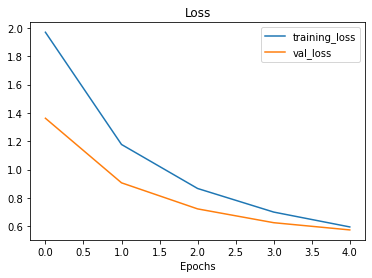

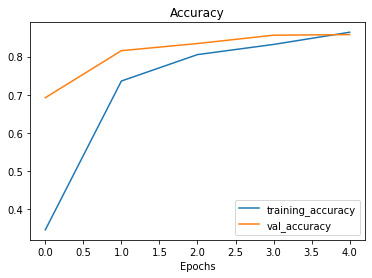

In [15]:
plot_loss_curves(history_0)

## Getting a Feature Vector from a Trained Model

What happened in the tf.keras.layers.GlobalAveragePooling2D() layer??

-- GlobalAveragePooling2D() takjes a transforms a 4D tensor into a 2D tensor by averaging the values across the inner axes

In [16]:
# Ex
input_shape = (1,4,4,3)

# create rand tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# pass rand tensor through a global 2d layer
global_avg_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D global average pooled random tensor:\n {global_avg_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_avg_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [17]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(global_max_pooled_tensor)
print(global_max_pooled_tensor.shape)

tf.Tensor([[0.9058464 1.1603122 1.6994323]], shape=(1, 3), dtype=float32)
(1, 3)


## 4 More Models

1.  use feature extraction learning with 1% of the data
1.  use feature extraction learning with 10% of the data
1.  use fine-tuning transfer learning with 1% of the data
1.  use fine-tuning transfer learning with 10% of the data

All with use data augmentation

In [18]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1 = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2021-11-16 22:56:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  81.2MB/s    in 1.6s    

2021-11-16 22:56:07 (81.2 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
# walk through the directory and list the files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [20]:
train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1,
                                                                   label_mode = 'categorical',
                                                                   image_size= (224, 224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = (224, 224))


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation Right Into the Model

Before we used params of ImageDataGenerator to augment our Trainig images, now we can build data augmentation into the model with 
tf.keras.layers.experimental.preprocessing

This is Good. Why?

- Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
 - Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU. 

- Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

To implement this we create a sequential model within a functional model

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [22]:
# augment the data, yo
data_augmentation = keras.Sequential([
     preprocessing.RandomFlip('horizontal'),
     preprocessing.RandomRotation(0.2),
     preprocessing.RandomZoom(0.2),
     preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2) 
     # could normalize here with preprocessing.Rescaling(1./255)                                
])



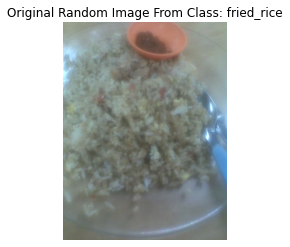

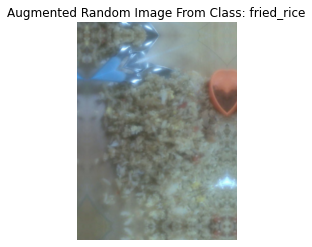

In [23]:
# view random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1.class_names) # choose a rand class
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.figure(1)
plt.imshow(img) # plot the target image
plt.title(f'Original Random Image From Class: {target_class}')
plt.axis(False);

# augment the image
augmented_image = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure(2)
plt.imshow(tf.squeeze(augmented_image)/255)# requires normalization after augmentation
plt.title(f"Augmented Random Image From Class: {target_class}")
plt.axis(False);

## Model 1

In [24]:
# setup shape & base model, freezing base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
inputs = layers.Input(shape = input_shape, name = 'input_layer')

# add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# give base model inputs (after aug) and dont train it
x = base_model(x, training=False)

# pool output features of bsae model
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# dense layer as output
outputs = layers.Dense(10, activation = 'softmax', name= 'output_layer')(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
history_1 = model_1.fit(train_data_1,
                        epochs = 5,
                        steps_per_epoch = len(train_data_1),
                        validation_data = test_data,
                        validation_steps = int(.25*len(test_data)),
                        callbacks = [create_tensorboard_callback('transfer_learning', 'efficientnetB0_1percent')])


Saving TensorBoard log files to: transfer_learning/efficientnetB0_1percent/20211116-225613
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


ValueError: ignored

In [ ]:
model_1.summary()

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)

In [ ]:
plot_loss_curves(history_1)

In [ ]:
## Model 2